# Sketch-RNN with Keras

In [1]:
# Path to data directory 
data_dir  = 'datasets'

# Path to the experiment directory that was created during training
exp_dir = 'sketch_rnnexperiments/cat\exp'

# Checkpoint file name (assumed in checkpoints folder within exp_dir)
weights_fname = 'weights.25--0.02.hdf5'

IMPORTING LIBRARIES

In [2]:
import os
import time
import copy
from utils import *
from seq2seqVAE_train import *
import seq2seqVAE as sketch_rnn_model
from seq2seqVAE import sample

In [3]:
# disable gpu access so this notebook can run during training (optional)
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

LIBRARIES FOR VISUALISATION(GIF,SVG IMAGES)

In [4]:

from IPython.display import SVG, display
import PIL
from PIL import Image
import glob
import matplotlib.pyplot as plt
import svgwrite 
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM
# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

                          THIS CELL HAS 3 IMPORTANT FUNCTIONS

1)draw_strokes():- This displays the decoded strokes as an SVG image in the notebook


2)animate():- This is used to save sequence of strokes as svg and png to display the animated gif

3)make_grid_svg():-This is used to generate a 2D grid of many vector drawings

In [29]:

def draw_strokes(data, factor=0.05, svg_filename = 'SVG/sample'):
    
    if not os.path.exists(os.path.dirname(svg_filename)):
        os.makedirs(os.path.dirname(svg_filename))
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (100 + max_x - min_x, 100 + max_y - min_y)
    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='cyan'))
    lift_pen = 1
    abs_x = 25 - min_x 
    abs_y = 25 - min_y

    p = "M%s,%s " % (abs_x, abs_y)
    command = "m"
    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i,0])/factor
        y = float(data[i,1])/factor
        lift_pen = data[i, 2]
        p += command+str(x)+","+str(y)+" "
    the_color = "red"
    stroke_width = 4
    dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("yellow"))
    dwg.save()
    display(SVG(dwg.tostring()))

    
    
def animate(data,factor=0.05,svg_filename='SVG/sample'):
    
    if not os.path.exists(os.path.dirname(svg_filename)):
        os.makedirs(os.path.dirname(svg_filename))
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)
    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='cyan'))
    lift_pen = 1
    abs_x = 25 - min_x 
    abs_y = 25 - min_y
    
    the_color = "red"
    stroke_width = 4
    p = "M%s,%s " % (abs_x, abs_y)
    command = "m"
    
    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i,0])/factor
        y = float(data[i,1])/factor
        lift_pen = data[i, 2]

        p += command+str(x)+","+str(y)+" "
        dwg = svgwrite.Drawing(svg_filename+str(i)+'.svg', size=dims)
        dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
        dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("yellow"))
        dwg.save()
        drawing = svg2rlg(svg_filename+str(i)+'.svg')
        renderPM.drawToFile(drawing,svg_filename+str(i)+'.png', fmt="PNG")
        
    dwg = svgwrite.Drawing(svg_filename+str(len(data))+'.svg', size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
    dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("yellow"))
    display(SVG(dwg.tostring()))
    dwg.save()
    drawing = svg2rlg(svg_filename+str(len(data))+'.svg')
    renderPM.drawToFile(drawing,svg_filename+str(len(data))+'.png', fmt="PNG")
    
    # Create the frames
    frames = []
    imgs = glob.glob("*.png")
    for i in range(len(data)):
        new_frame = Image.open(r"C:\Users\Amey Vijay Shimpi\Desktop\Sketch_gen-master\SVG\sample"+str(i)+".png")
        frames.append(new_frame)
     
    #Save into a GIF file that loops forever
    frames[0].save('animation.gif', format='GIF',
                append_images=frames[1:],
                save_all=True,
                duration=300, loop=0)
                  

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
    def get_start_and_end(x):
        x = np.array(x)
        x = x[:, 0:2]
        x_start = x[0]
        x_end = x.sum(axis=0)
        x = x.cumsum(axis=0)
        x_max = x.max(axis=0)
        x_min = x.min(axis=0)
        center_loc = (x_max+x_min)*0.5
        return x_start-center_loc, x_end
    x_pos = 0.0
    y_pos = 0.0
    result = [[x_pos, y_pos, 1]]
    for sample in s_list:
        s = sample[0]
        grid_loc = sample[1]
        grid_y = grid_loc[0]*grid_space+grid_space*0.5
        grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
        start_loc, delta_pos = get_start_and_end(s)
    
        loc_x = start_loc[0]
        loc_y = start_loc[1]
        new_x_pos = grid_x+loc_x
        new_y_pos = grid_y+loc_y
        result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])
    
        result += s.tolist()
        result[-1][2] = 1
        x_pos = new_x_pos+delta_pos[0]
        y_pos = new_y_pos+delta_pos[1]
    return np.array(result)

Read parameter file and load data:

In [30]:
with open(os.path.join(exp_dir,'logs', 'model_config.json'), 'r') as f:
    model_params = json.load(f)
model_params = DotDict(model_params)   
[train_set, valid_set, test_set, hps_model] = load_dataset(data_dir, model_params)

Loaded 70000/2500/2500 from cat.npz
Dataset combined: 75000 (70000/2500/2500), avg len 69
model_params.max_seq_len: 129
total images <= max_seq_len is 70000
total images <= max_seq_len is 2500
total images <= max_seq_len is 2500
normalizing_scale_factor  43.17017


Build a Seq2seq variational autoencoder model and load weights from checkpoint:

In [31]:
weights = os.path.join(exp_dir,'checkpoints',weights_fname) # checkpoint path
seq2seq = Seq2seqModel(model_params)  # build model
seq2seq.load_trained_weights(weights) # load checkpoint
seq2seq.make_sampling_models()  # build sub models that are used to infuse inputs and probe values of intermediate layers

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 129, 5)]     0                                            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 512)          536576      encoder_input[0][0]              
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 128)          65664       bidirectional_3[0][0]            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 128)          65664       bidirectional_3[0][0]            
___________________________________________________________________________________________


The encode() function takes the input strokes and projects it into latent space z

In [32]:

def encode(input_strokes, draw=False):
    strokes = to_big_strokes(input_strokes, max_len=model_params['max_seq_len']-1).tolist()
    strokes.insert(0, [0, 0, 1, 0, 0])
    seq_len = [len(input_strokes)]
    if draw:
        draw_strokes(to_normal_strokes(np.array(strokes)))
    strokes = np.expand_dims(strokes, axis=0)
    return seq2seq.sample_models['encoder_model'].predict(strokes)


The decode() function predicts and produces the output sketch

In [33]:
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.05):
    z = None
    if z_input is not None:
        z = z_input
    sample_strokes, m = sample(seq2seq, seq_len=model_params.max_seq_len, temperature=temperature, z=z)
    strokes = to_normal_strokes(sample_strokes)
    if draw_mode:
        draw_strokes(strokes, factor)
    return strokes

Let's take a random sketch from the unseen test set and draw it:

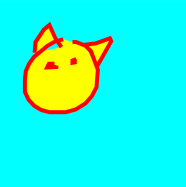

In [34]:
# Get a sample drawing from the test set, and render it to .svg
stroke = test_set.random_sample()
draw_strokes(stroke,svg_filename = '/tmp/sketch_rnn/svg/sample.svg')


Now we will encode this sketch into the latent space.

Note that our encoder was constructed to be non-deterministic. So the same sketch will be encoded to different latent representations each time we encode.

In [35]:
z = encode(stroke)

Now we decode this encoded representation back to a sketch:

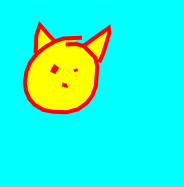

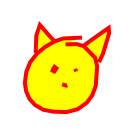

In [36]:
x = decode(z, temperature=0.5) # convert z back to drawing at temperature of 0.5
animate(x)

# What is temperature ?

The temperature variable controls the level of randomness we would like our samples to have during the
sampling 



Let's decode our cat using varying temperature values between 0.1 and 1 and see how 'creative' our model can get:

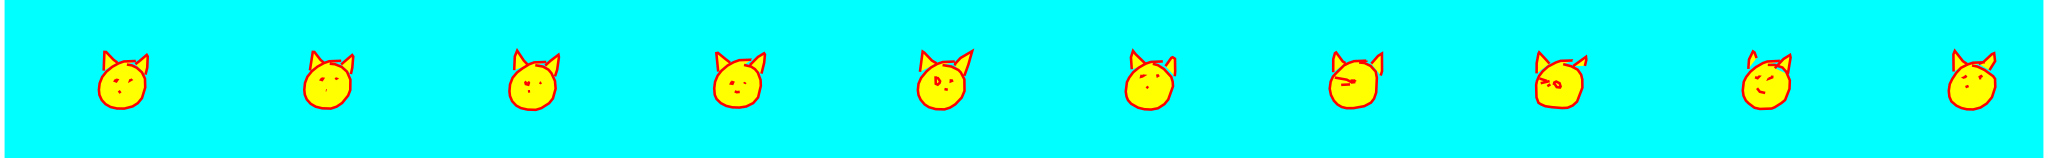

In [37]:
stroke_list = []
for i in range(10):
  stroke_list.append([decode(z, draw_mode=False, temperature=0.1*i+0.1), [0, i]])
stroke_grid = make_grid_svg(stroke_list)
draw_strokes(stroke_grid)

Interpolation between two cats

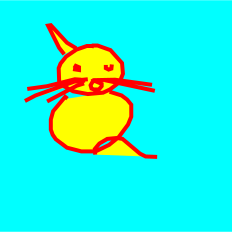

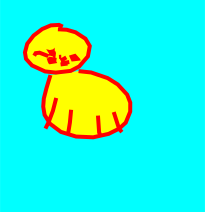

In [38]:
z0 = z

# Get a sample drawing from the test set, and render it to .svg
stroke = test_set.random_sample()
draw_strokes(stroke,svg_filename = '/tmp/sketch_rnn/svg/sample.svg')
z1 = encode(stroke)
_ = decode(z1) # convert z back to drawing at temperature of 0.5

z1 = np.squeeze(z1)
z0 = np.squeeze(z0)

Function for interpolation

In [39]:
def interpolate_z(z_0, z_1, draw=True):
    z_list = [] # interpolate spherically between z0 and z1
    N = 10
    for t in np.linspace(0, 1, N):
        z_list.append(slerp(z_0, z_1, t))
    # for every latent vector in z_list, sample a vector image
    reconstructions = []
    for i in range(N):
        reconstructions.append([decode(np.expand_dims(z_list[i],axis=0), draw_mode=False), [0, i]])
    stroke_grid = make_grid_svg(reconstructions)
    if draw:
        draw_strokes(stroke_grid)

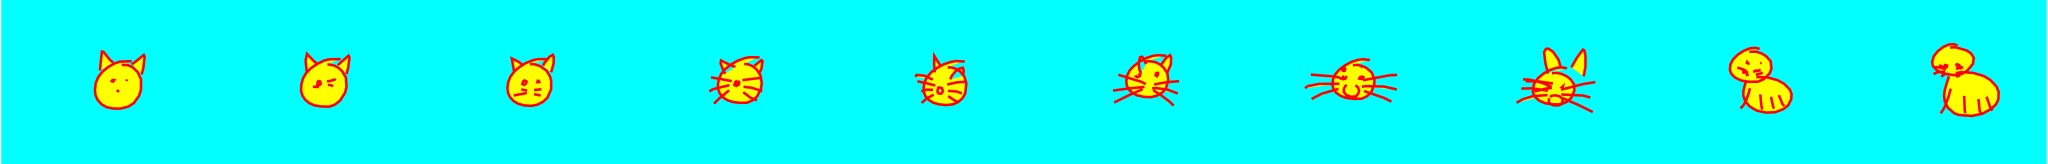

In [40]:
interpolate_z(z0,z1)

Since this is a Variational Autoencoder, we don't need to use an actual sketch in order to generate new sketches. We can sample randomly within the latent space and feed the result to the decoder.

Let's let our model draw some random cats!

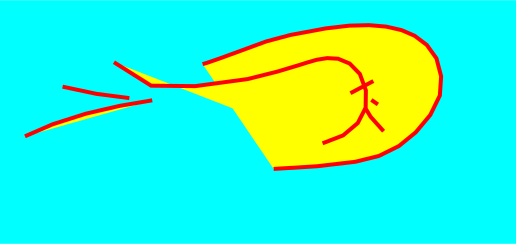

In [41]:
random_cat_1 = np.expand_dims(np.random.randn(model_params.z_size),0)
_ = decode(random_cat_1)

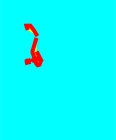

In [42]:
random_cat_2 = np.expand_dims(np.random.randn(model_params.z_size),0)
_ = decode(random_cat_2)

Again, we can intepulate between our 2 random cats:

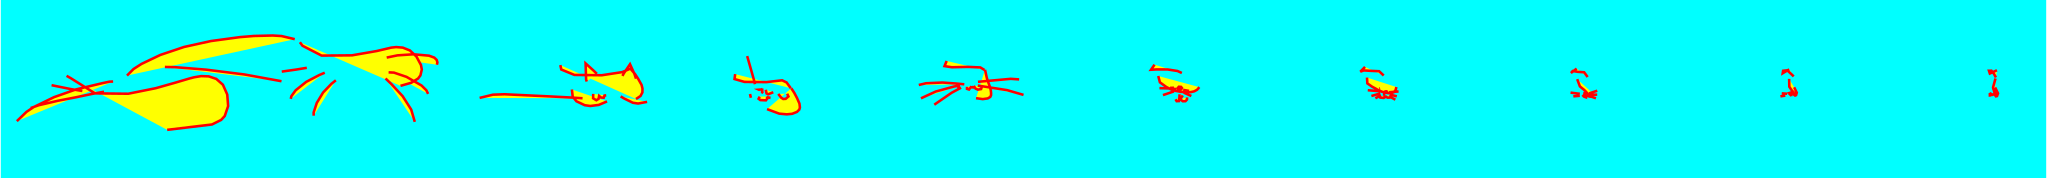

In [43]:
random_cat_1 = np.squeeze(random_cat_1)
random_cat_2 = np.squeeze(random_cat_2)
# interpolate_z(random_cat_2,random_cat_2)
interpolate_z(random_cat_1,random_cat_2)